#  This document is the exploratory data analysis for problems of anomaly with some of Sysmex's analyzers

## Part 1: Exploratory Data Analysis

This part is to explore data, transform and understand the data provided by Sysmex

In [161]:
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split 
import scipy.stats as stats
import math
from IPython.display import display, HTML



# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [5]:
qc_data = pd.read_csv('~/downloads/Specific QC Lot Number Results.csv', header =None)
qc_data.columns =['product_id', 'qc_lot', 'time', 'w-x', 'w-y', 'w-z']
machine_data = pd.read_excel('~/downloads/Reference Set A Result Set.xlsx')


In [6]:
test_flagging = pd.read_csv('~/documents/Sysmex Analyzer Analytics/Data/Test Flagging Query Data Set.csv', header = None)
x_bar_m = pd.read_csv('~/documents/Sysmex Analyzer Analytics/Data/XBarM Result Set for Steve (CSV Form Revised).csv', header = None)

In [7]:
test_flagging.columns = ['Prod_ID', 'Count_Date', 'IPU_Ver', 'Count_Val', 'Counter']
x_bar_m.columns = ['Prod_ID', 'X_Bar_Run_Date_Time', 'X_Bar_M_X','X_Bar_M_Y', 'X_Bar_M_Z']

test_flagging.Prod_ID = test_flagging.Prod_ID.astype(str)
test_flagging.Count_Date = pd.to_datetime(test_flagging.Count_Date)


x_bar_m.Prod_ID = x_bar_m.Prod_ID.astype(str)
x_bar_m.X_Bar_Run_Date_Time = pd.to_datetime(x_bar_m.X_Bar_Run_Date_Time)




In [8]:
x_bar_m[['Prod_ID','X_Bar_Run_Date_Time']].describe()

,Prod_ID,X_Bar_Run_Date_Time
count,5033413,5033413
unique,3610,1224545
top,139261,2016-12-08 13:04:49
freq,40588,38
first,NaN,2016-11-17 14:18:51
last,NaN,2017-05-25 02:22:10


In [9]:
x_bar_m.describe()

,X_Bar_M_X,X_Bar_M_Y,X_Bar_M_Z
count,5.033413e+06,5.033413e+06,5.033413e+06
mean,1.500166e+03,4.903119e+02,8.703163e+02
std,1.838994e+01,1.761530e+01,2.137695e+01
min,4.000000e+00,1.000000e+00,3.000000e+00
25%,1.490000e+03,4.780000e+02,8.560000e+02
50%,1.501000e+03,4.900000e+02,8.700000e+02
75%,1.512000e+03,5.020000e+02,8.840000e+02
max,3.642000e+03,1.239000e+03,2.163000e+03


In [10]:
np.sum(x_bar_m.isnull())

Prod_ID                0
X_Bar_Run_Date_Time    0
X_Bar_M_X              0
X_Bar_M_Y              0
X_Bar_M_Z              0
dtype: int64

In [14]:
test_flagging[['Prod_ID','Count_Date', 'IPU_Ver', 'Counter']].describe()

,Prod_ID,Count_Date,IPU_Ver,Counter
count,4957240,4957240,4957240,4957240
unique,3681,146,17,11
top,126556,2017-05-19 00:00:00,00-16 (Build 7),CBCCounter
freq,244802,42509,3108178,973334
first,NaN,2017-01-01 00:00:00,NaN,NaN
last,NaN,2017-05-26 00:00:00,NaN,NaN


In [12]:
## Function to return a list of products that has more than one IPU versions
# def get_multi_IPU():
#     multi_ipu_machine = pd.DataFrame(columns = machine_data.columns)
#     Unique_Prod_ID = np.unique(machine_data.Prod_ID)
#     for prod_id in Unique_Prod_ID:
#         k = machine_data[machine_data.Prod_ID ==prod_id]
#         if k.shape[0]>1:
#             multi_ipu_machine = multi_ipu_machine.append(k)
#     multi_ipu_machine.sort_values(['Prod_ID', 'Upgrade_Date'], ascending = [False, False])
#     return multi_ipu_machine

def get_IPU_Ver(prod_id, tran_date):
    machine_mini_list = machine_data[machine_data['Prod_ID'] == prod_id]
    t = machine_mini_list.shape[0]
    if t ==0: return None
    k=0
#     print(machine_mini_list.shape)
#     print('hello')
    for i in range(t):
#         print('before print date')
#         print('date is', machine_mini_list.values[i,1])
        if machine_mini_list.Upgrade_Date.iloc[i] < tran_date: k=i
    
    return machine_mini_list.IPU_Ver.iloc[k]

#get_IPU_Ver('125862',pd.to_datetime('2017-01-19'))


IPU_Ver =[]
for i in range(test_flagging.shape[0]):
    prod_id = test_flagging['Prod_ID'].iloc[i]
    tran_date = test_flagging.Count_Date.iloc[i] 
    IPU_Ver.append(get_IPU_Ver(prod_id, tran_date))

test_flagging['IPU_Ver'] = IPU_Ver
    

KeyError: 'Prod_ID'

In [ ]:
counters = np.unique(test_flagging.Counter)
days = np.unique(test_flagging.Count_Date)

In [ ]:
for counter in counters:
    counter_running_value =0
    for date in days:
        day_data = test_flagging[(test_flagging.Counter ==counter)&(test_flagging.Count_Date ==date)]
        day_data[day_data.Count_Val<counter_running_value].Count_Val += counter_running_value
        counter_running_value = np.max(day_data.Count_Val)
        test_flagging[(test_flagging.Counter ==counter)&(test_flagging.Count_Date ==date)] = day_data

/Users/giang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [ ]:
test_flagging[(test_flagging.Prod_ID =='158238')&(test_flagging.Count_Date=='2017-05-11')]

In [ ]:
values = test_flagging[test_flagging.Counter =='WBModeCounter'].Count_Val.values


In [ ]:
min(values)

In [ ]:
X =test_flagging[(test_flagging.Counter!='CBCCounter')&(test_flagging.Counter!='DIFFCounter')].groupby(['IPU_Ver','Prod_ID','Counter','Count_Date'])['Count_Val'].aggregate(['min','max'])



In [ ]:
X.loc[(slice(None), ['158238'],slice(None),['2017-05-11']),:]

In [ ]:
X_Updated = X['max']-X['min']
X_Updated=X_Updated.unstack().dropna()

In [ ]:
X_Updated[X_Updated.PLTAbnDistribIPCounter==3383]

In [385]:
X_Updated.AtypicalLymphIPCounter = X_Updated.AtypicalLymphIPCounter/X_Updated.WBModeCounter


X_Updated.DimorphicPopulationIPCounter = X_Updated.DimorphicPopulationIPCounter/X_Updated.WBModeCounter
X_Updated.IGPresentIPCounter = X_Updated.IGPresentIPCounter/X_Updated.WBModeCounter
X_Updated.LeftShiftIPCounter = X_Updated.LeftShiftIPCounter/X_Updated.WBModeCounter


X_Updated.PLTAbnDistribIPCounter = X_Updated.PLTAbnDistribIPCounter/X_Updated.WBModeCounter
X_Updated.PLTAbnSctIPCounter = X_Updated.PLTAbnSctIPCounter/X_Updated.WBModeCounter


X_Updated.RETAbnSctIPCounter = X_Updated.RETAbnSctIPCounter/X_Updated.WBModeCounter
X_Updated.WBCAbnSctCounter = X_Updated.WBCAbnSctCounter/X_Updated.WBModeCounter












/Users/giang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [1]:
X_Updated.describe()

NameError: name 'X_Updated' is not defined

In [ ]:
machine_data[machine_data.Prod_ID=='139261']

In [ ]:
X

In [15]:
machine_data.columns=['Prod_ID', 'Upgrade_Date', 'IPU_Ver', 'Ser_No', 'Model_ID']
qc_data.columns =['Prod_ID', 'QC_Lot', 'QC_Time', 'W-X', 'W-Y', 'W-Z']





In [16]:
print('number of products in machine data: {:32,d}'.format(len(np.unique(machine_data['Prod_ID']))))
print('number of records in machine data:  {:32,d}'.format( len((machine_data['Prod_ID']))))
print('number of products in QC data:      {:32,d}'.format( len(np.unique(qc_data['Prod_ID']))))
print('number of records in QC data:       {:32,d}'.format( len((qc_data['Prod_ID']))))

print('number of records in QC data with zero W-X data {:20,d}'.format( np.sum((qc_data['W-X']==0))))
print('number of records in QC data with zero W-Y data {:20,d}'.format(  np.sum((qc_data['W-Y']==0))))
print('number of records in QC data with zero W-Z data {:20,d}'.format(  np.sum((qc_data['W-Z']==0))))

print('number of records in QC data with zero W-Z, W-Y, W-Z data {:10,d}'.format(np.sum((qc_data['W-X']==0)&(qc_data['W-Y']==0)&(qc_data['W-Z']==0))))

number of products in machine data:                            3,376
number of records in machine data:                             3,468
number of products in QC data:                                 3,807
number of records in QC data:                              2,435,412
number of records in QC data with zero W-X data               18,127
number of records in QC data with zero W-Y data               18,078
number of records in QC data with zero W-Z data               18,090
number of records in QC data with zero W-Z, W-Y, W-Z data     18,071


## Clean up data and create a joined dataset
In this step, we clean out records where W-X, W-Y, W-Z are all zeros. Also, we temporarily remove historical of software upgrade for each product ID just to keep one record for one machine with the latest software version then merge with QC data to create consolidated machine_qc dataset for analysis purpose

In [17]:
clean_qc_data = qc_data[((qc_data['W-X']!=0)&(qc_data['W-Y']!=0)&(qc_data['W-Z']!=0))]
machine_data = machine_data.sort_values(by =['Prod_ID', 'Upgrade_Date'], ascending = [True, True])
clean_qc_data['Prod_ID'] = clean_qc_data['Prod_ID'].astype(str)

clean_qc_data['QC_Time'] = pd.to_datetime(clean_qc_data['QC_Time'])

machine_data['Prod_ID'] = machine_data['Prod_ID'].astype(str)

machine_data['Upgrade_Date'] = pd.to_datetime(machine_data['Upgrade_Date'])


unique_machine_data=machine_data.drop_duplicates(subset='Prod_ID', keep ='first')
qc_machine_data = pd.merge(clean_qc_data, unique_machine_data, how ='left')




print('number of records for clean QC data:       {:32,d}'.format(len(clean_qc_data['Prod_ID'])))
print('number of records for unique machine data: {:32,d}'.format(len(unique_machine_data['Prod_ID'])))
print('number of records in consol data set       {:32,d}'.format(len(qc_machine_data['Prod_ID'])))

/Users/giang/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/giang/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


number of records for clean QC data:                              2,417,282
number of records for unique machine data:                            3,376
number of records in consol data set                              2,417,282


There're records with null values due to missing master machine records

In [18]:
np.sum(qc_machine_data.isnull())

Prod_ID              0
QC_Lot               0
QC_Time              0
W-X                  0
W-Y                  0
W-Z                  0
Upgrade_Date    217957
IPU_Ver         217957
Ser_No          217957
Model_ID        217957
dtype: int64

In [19]:
qc_machine_data=qc_machine_data.dropna()
qc_machine_data = qc_machine_data.sort_values(['QC_Lot', 'Prod_ID','QC_Time'], ascending = [True, True, True])


In [20]:


transformed_qc_machine_data = qc_machine_data[['QC_Lot', 'W-X', 'W-Y', 'W-Z', 'IPU_Ver', 'Model_ID']]
transformed_qc_machine_data = pd.get_dummies(transformed_qc_machine_data, columns =['IPU_Ver', 'Model_ID', 'QC_Lot']).values


In [149]:
train_data = transformed_qc_machine_data
test_data = transformed_qc_machine_data

In [144]:
## Function to return a list of products that has more than one IPU versions
# def get_multi_IPU():
#     multi_ipu_machine = pd.DataFrame(columns = machine_data.columns)
#     Unique_Prod_ID = np.unique(machine_data.Prod_ID)
#     for prod_id in Unique_Prod_ID:
#         k = machine_data[machine_data.Prod_ID ==prod_id]
#         if k.shape[0]>1qc:
#             multi_ipu_machine = multi_ipu_machine.append(k)
#     multi_ipu_machine.sort_values(['Prod_ID', 'Upgrade_Date'], ascending = [False, False])
#     return multi_ipu_machine

def get_IPU_Ver(prod_id, tran_date):
    machine_mini_list = machine_data[machine_data['Prod_ID'] == prod_id]
    t = machine_mini_list.shape[0]
    if t ==0: return None
    k=0
#     print(machine_mini_list.shape)
#     print('hello')
    for i in range(t):
#         print('before print date')
#         print('date is', machine_mini_list.values[i,1])
        if machine_mini_list.Upgrade_Date.iloc[i] < tran_date: k=i
    
    return machine_mini_list.IPU_Ver.iloc[k]

#get_IPU_Ver('125862',pd.to_datetime('2017-01-19'))
qc_machine_data.head()


IPU_Ver =[]
for i in range(qc_machine_data.shape[0]):
    prod_id = qc_machine_data['Prod_ID'].iloc[i]
    tran_date = qc_machine_data.QC_Time.iloc[i] 
    IPU_Ver.append(get_IPU_Ver(prod_id, tran_date))

qc_machine_data['IPU_Ver'] = IPU_Ver
    
# print(prod_id)

In [22]:
qc_machine_data.describe(include =['O'])

,Prod_ID,QC_Lot,IPU_Ver,Ser_No,Model_ID
count,2199325,2199325,2199325,2199325,2199325
unique,3321,23,10,3319,4
top,155786,QC-70371102,00-16 (Build 7),21709,XN-10
freq,2148,190338,1948948,2148,2119867


In [150]:
qc_machine_data[qc_machine_data.Prod_ID =='125862']

,Prod_ID,QC_Lot,QC_Time,W-X,W-Y,W-Z,Upgrade_Date,IPU_Ver,Ser_No,Model_ID
121,125862,QC-70371101,2017-03-16 07:57:51,1763,1184,1247,2017-01-18 17:22:13.190,00-16 (Build 7),11270,XN-20
122,125862,QC-70371101,2017-03-22 09:39:57,1761,1181,1274,2017-01-18 17:22:13.190,00-16 (Build 7),11270,XN-20
123,125862,QC-70371101,2017-03-22 09:49:16,1757,1202,1271,2017-01-18 17:22:13.190,00-16 (Build 7),11270,XN-20
124,125862,QC-70371101,2017-03-22 10:07:43,1760,1198,1265,2017-01-18 17:22:13.190,00-16 (Build 7),11270,XN-20
125,125862,QC-70371101,2017-03-22 10:25:11,1748,1173,1254,2017-01-18 17:22:13.190,00-16 (Build 7),11270,XN-20
126,125862,QC-70371101,2017-03-22 10:41:21,1751,1190,1261,2017-01-18 17:22:13.190,00-16 (Build 7),11270,XN-20
127,125862,QC-70371101,2017-03-22 10:49:25,1761,1158,1278,2017-01-18 17:22:13.190,00-16 (Build 7),11270,XN-20
128,125862,QC-70371101,2017-03-22 11:43:44,1751,1177,1263,2017-01-18 17:22:13.190,00-16 (Build 7),11270,XN-20
129,125862,QC-70371101,2017-03-24 12:23:36,1765,1215,1261,2017-01-18 17:22:13.190,00-16 (Build 7),11270,XN-20
130,125862,QC-70371101,2017-03-24 13:08:49,1759,1185,1250,2017-01-18 17:22:13.190,00-16 (Build 7),11270,XN-20


In [24]:
qc_machine_data[['Upgrade_Date', 'QC_Time']].dropna().describe()

,Upgrade_Date,QC_Time
count,2199325,2199325
unique,3303,1851490
top,2017-05-19 04:00:57.837000,2017-05-18 07:32:35
freq,3310,8
first,2016-11-25 14:33:00.117000,2017-01-06 10:36:47
last,2017-05-24 14:04:56.943000,2017-05-31 08:28:32


In [25]:
qc_machine_data['IPU_Ver'].value_counts()

00-16 (Build 7)      1948948
00-19D (Build 13)     121243
00-17A (Build 1)       36938
00-19C (Build 1)       35064
00-18 (Build 4)        18534
00-19D (Build 12)      17299
00-19D (Build 9)        9379
00-19 (Build 9)         7757
00-15 (Build 5)         4116
00-20 (Build 8)           47
Name: IPU_Ver, dtype: int64

In [26]:
qc_machine_data.groupby('IPU_Ver')['Prod_ID'].describe().unstack()

,count,unique,top,freq
IPU_Ver,,,,
00-15 (Build 5),4116,7,148431,1128
00-16 (Build 7),1948948,2761,155786,2148
00-17A (Build 1),36938,83,139687,1161
00-18 (Build 4),18534,30,150007,1030
00-19 (Build 9),7757,11,127576,1553
00-19C (Build 1),35064,42,137876,1577
00-19D (Build 12),17299,37,169226,658
00-19D (Build 13),121243,341,121288,1487
00-19D (Build 9),9379,8,160464,1300


In [27]:
def count_unique(x):
    np_arr = x.values
    output = []
    for i in range(np_arr.shape[1]):
        output.append(len(np.unique(np_arr[:,i])))
    return  pd.DataFrame(np.array(output).reshape(-1,len(x.columns)), columns = x.columns)

qc_machine_data.groupby(['IPU_Ver', 'QC_Lot'])['Prod_ID', 'Model_ID'].apply(count_unique)

Prod_ID  Model_ID
IPU_Ver           QC_Lot                          
00-15 (Build 5)   QC-70371101 0        2         1
                  QC-70371102 0        2         1
                  QC-70371103 0        2         1
                  QC-70371301 0        3         1
                  QC-70371302 0        3         1
                  QC-70381101 0        2         1
                  QC-70381102 0        2         1
                  QC-70381103 0        2         1
                  QC-70391101 0        3         1
                  QC-70391102 0        3         1
                  QC-70391103 0        3         1
                  QC-70931101 0        2         1
                  QC-70931102 0        2         1
                  QC-70931103 0        2         1
                  QC-70931301 0        3         1
                  QC-70931302 0        3         1
                  QC-70941101 0        2         1
                  QC-70941102 0        2         1
                  QC-70941103 0        2         1
                  QC-70951101 0        3         1
                  QC-70951102 0        3         1
                  QC-70951103 0        3         1
00-16 (Build 7)   QC-70371101 0     1343         2
                  QC-70371102 0     1346         2
                  QC-70371103 0     1346         2
                  QC-70371301 0     1620         2
                  QC-70371302 0     1620         2
                  QC-70371601 0        1         1
                  QC-70381101 0     1378         1
                  QC-70381102 0     1383         1
...                                  ...       ...
00-19D (Build 13) QC-70371302 0      145         3
                  QC-70381101 0      104         3
                  QC-70381102 0      104         3
                  QC-70381103 0      104         3
                  QC-70391101 0       17         2
                  QC-70391102 0       17         2
                  QC-70391103 0       17         2
                  QC-70931101 0      189         3
                  QC-70931102 0      195         3
                  QC-70931103 0      195         3
                  QC-70931301 0      143         3
                  QC-70931302 0      145         3
                  QC-70941101 0      117         3
                  QC-70941102 0      118         3
                  QC-70941103 0      117         3
                  QC-70951101 0       15         2
                  QC-70951102 0       17         2
                  QC-70951103 0       18         2
00-19D (Build 9)  QC-70371101 0        8         1
                  QC-70371102 0        8         1
                  QC-70371103 0        8         1
                  QC-70931101 0        8         1
                  QC-70931102 0        8         1
                  QC-70931103 0        8         1
00-20 (Build 8)   QC-70391101 0        1         1
                  QC-70391102 0        1         1
                  QC-70391103 0        1         1
                  QC-70951101 0        1         1
                  QC-70951102 0        1         1
                  QC-70951103 0        1         1

[177 rows x 2 columns]

In [28]:
np.corrcoef(qc_machine_data[qc_machine_data.Prod_ID == '155786']['W-X'],qc_machine_data[qc_machine_data.Prod_ID == '155786']['W-Y']) 

array([[ 1.        ,  0.94977836],
       [ 0.94977836,  1.        ]])

In [145]:
import random as rd
max_ind = train_data.shape[0]
def sm_next_batch(batch_size, n_steps):
    X = []
    Y = []
    for i in range(batch_size):
        start = rd.randint(0, max_ind-n_steps-1)
        ys1 = train_data[start: start+n_steps]
        ys2 = train_data[start+1: start+n_steps+1,0:3]
        X.append(ys1)
        Y.append(ys2)
    X = np.array(X).reshape(-1, n_steps, 40)
    Y = np.array(Y).reshape(-1, n_steps, 3)
    
    return X, Y 
   

max_test_ind = test_data.shape[0]

def sm_test_random_batch(batch_size, n_steps):
    X = []
    Y = []
    for i in range(batch_size):
        start = rd.randint(0, max_test_ind-n_steps-1)
        ys1 = test_data[start: start+n_steps]
        ys2 = test_data[start+1: start+n_steps+1,0:3]
        X.append(ys1)
        Y.append(ys2)
    X = np.array(X).reshape(-1, n_steps, 40)
    Y = np.array(Y).reshape(-1, n_steps, 3)
    
    return X, Y 

def format_test_data(test_data, n_steps):
    X = []
    Y = []
    max_test_range = test_data.shape[0]

    for start in range(max_test_range//n_steps):
        
        ys1 = test_data[start*n_steps: start*n_steps+n_steps]
        ys2 = test_data[start*n_steps+1: start*n_steps+n_steps+1,0:3]
        X.append(ys1)
        Y.append(ys2)
        
    X = np.array(X).reshape(-1, n_steps, 40)
    Y = np.array(Y).reshape(-1, n_steps, 3)
    return X, Y 
   

In [146]:
tf.reset_default_graph()

n_steps = 120
n_inputs = 40
n_neurons = 100
n_outputs = 3
learning_rate = 0.001



X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)


loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [156]:
sm_n_steps = 120


X_test, Y_test = format_test_data(test_data, sm_n_steps)

print(X_test.shape, Y_test.shape)


(18327, 120, 40) (18327, 120, 3)


In [157]:
n_iterations = 10000
sm_batch_size = 50
sm_n_steps = 120
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = sm_next_batch(sm_batch_size, sm_n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    save_path = saver.save(sess, "/tmp/my_model_final.ckpt")

0 	MSE: 3.8621e+10
100 	MSE: 4.36665e+08
200 	MSE: 7.80961e+07
300 	MSE: 2.03158e+07
400 	MSE: 1.34685e+07
500 	MSE: 1.68109e+07
600 	MSE: 1.19167e+07
700 	MSE: 2.38871e+07
800 	MSE: 1.06973e+07
900 	MSE: 8.49204e+06
1000 	MSE: 1.21054e+07
1100 	MSE: 1.18939e+07
1200 	MSE: 9.12678e+06
1300 	MSE: 9.2766e+06
1400 	MSE: 9.83998e+06
1500 	MSE: 5.98721e+06
1600 	MSE: 9.67512e+06
1700 	MSE: 6.76794e+06
1800 	MSE: 1.07313e+07
1900 	MSE: 5.40085e+06
2000 	MSE: 9.82361e+06
2100 	MSE: 8.37362e+06
2200 	MSE: 7.32708e+06
2300 	MSE: 9.86562e+06
2400 	MSE: 8.6168e+06
2500 	MSE: 1.28011e+07
2600 	MSE: 6.99471e+06
2700 	MSE: 7.94991e+06
2800 	MSE: 8.53847e+06
2900 	MSE: 5.52172e+06
3000 	MSE: 9.43416e+06
3100 	MSE: 8.29579e+06
3200 	MSE: 5.47981e+06
3300 	MSE: 7.1061e+06
3400 	MSE: 5.40575e+06
3500 	MSE: 7.49075e+06
3600 	MSE: 8.6154e+06
3700 	MSE: 6.35159e+06
3800 	MSE: 1.10856e+07
3900 	MSE: 8.23529e+06
4000 	MSE: 1.1426e+07
4100 	MSE: 1.07562e+07
4200 	MSE: 7.15568e+06
4300 	MSE: 7.04622e+06
4400 	

In [158]:
with tf.Session() as sess:
    saver.restore(sess,"/tmp/my_model_final.ckpt")
    X_test, Y_test = format_test_data(test_data, sm_n_steps)
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    mse = loss.eval(feed_dict={X: X_test, y: Y_test})


INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


In [152]:
Y_test.shape

(18327, 120, 3)

In [159]:
actual = Y_test.reshape(-1,3)
pred = y_pred.reshape(-1,3)
var = 1/3*(abs(actual[:,0]-pred[:,0])+abs(actual[:,1]-pred[:,1])+abs(actual[:,2]-pred[:,2]))


x=np.argwhere(var>np.percentile(var,99.995)).reshape(-1)

actual[x,:]

array([[1769,  400, 1249],
       [2180,  380, 1899],
       [ 910,  590, 1054],
       [ 610,  400, 1496],
       [1746, 2168, 1401],
       [1461,  425,  826],
       [1120,  680,  967],
       [ 830,  730, 1075],
       [2260, 1210,  115],
       [ 700,  580,  385],
       [ 830,  630, 1056],
       [ 960,  750,  940],
       [ 870,  410,  565],
       [1760, 2281, 1179],
       [ 750,  720, 1050],
       [1980,  395, 1886],
       [2130, 1530,  900],
       [1260, 1640, 1360],
       [1080,  460,  533],
       [1070,  750,  683],
       [1310, 1470, 1250],
       [1090,  222, 1152],
       [1601, 2388, 1580],
       [1628,  565, 1642],
       [1280,  340, 1210],
       [2010,  830,  180],
       [1120,  750,  840],
       [1320,  740,  290],
       [1430,  480,  790],
       [1613, 2010, 1573],
       [ 990,  650,  950],
       [1705, 1872, 1514],
       [ 880,  840, 1085],
       [ 830,  870, 1167],
       [ 890,  590, 1015],
       [2140,  700,  160],
       [1710,  820,  210],
 

In [154]:
actual = Y_test.reshape(-1,3)
pred = y_pred.reshape(-1,3)
var = 1/3*(abs(actual[:,0]-pred[:,0])+abs(actual[:,1]-pred[:,1])+abs(actual[:,2]-pred[:,2]))
log_var =np.log(var)
zstat = stats.t.ppf(q=1-0.00001,  # Quantile to check
            df=len(log_var)-1)
s=np.std(log_var)
upper_limit = np.exp(np.mean(log_var)+zstat*s/math.sqrt(len(log_var)))
lower_limit = np.exp(np.mean(log_var)-zstat*s/math.sqrt(len(log_var)))
print(upper_limit, lower_limit)

x_upper=np.argwhere(var>upper_limit).reshape(-1)

actual[x_upper,:].shape

7.4221262301 7.39290643006


(1092205, 3)

(array([  6.00000000e+00,   1.60000000e+01,   9.80000000e+01,
          3.84000000e+02,   1.63800000e+03,   7.02100000e+03,
          2.71620000e+04,   9.30000000e+04,   2.42421000e+05,
          3.98042000e+05,   3.59171000e+05,   1.80716000e+05,
          5.69530000e+04,   1.95610000e+04,   9.24900000e+03,
          2.68500000e+03,   8.83000000e+02,   1.98000000e+02,
          8.40000000e+01,   3.20000000e+01]),
 array([-2.85464083, -2.37074137, -1.88684192, -1.40294247, -0.91904302,
        -0.43514357,  0.04875588,  0.53265533,  1.01655478,  1.50045423,
         1.98435369,  2.46825314,  2.95215259,  3.43605204,  3.91995149,
         4.40385094,  4.88775039,  5.37164984,  5.85554929,  6.33944874,
         6.8233482 ]),
 <a list of 20 Patch objects>)

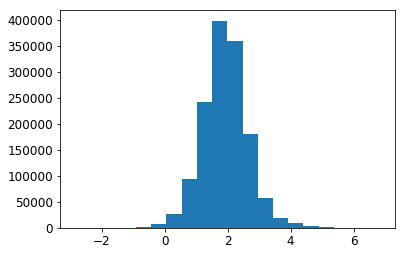

6.77933549289 6.76033067897


In [165]:
machines = qc_machine_data.iloc[x+1]
HTML(machines.to_html())

,Prod_ID,QC_Lot,QC_Time,W-X,W-Y,W-Z,Upgrade_Date,IPU_Ver,Ser_No,Model_ID
80769,146703,QC-70371101,2017-03-30 09:00:25,1769,400,1249,2017-04-03 15:28:20.933,00-16 (Build 7),17627,XN-10
80770,146703,QC-70371101,2017-03-30 09:32:19,2180,380,1899,2017-04-03 15:28:20.933,00-16 (Build 7),17627,XN-10
147099,158383,QC-70371101,2017-04-21 08:30:12,910,590,1054,2017-05-19 13:59:31.820,00-16 (Build 7),23155,XN-10
175931,164173,QC-70371101,2017-03-27 09:24:25,610,400,1496,2017-05-21 06:00:07.777,00-16 (Build 7),25777,XN-10
175934,164173,QC-70371101,2017-03-27 09:34:21,1746,2168,1401,2017-05-21 06:00:07.777,00-16 (Build 7),25777,XN-10
241731,137991,QC-70371102,2017-02-25 04:20:39,1461,425,826,2017-04-21 14:59:44.647,00-16 (Build 7),14318,XN-10
244630,138294,QC-70371102,2017-02-24 00:58:24,1120,680,967,2017-01-06 10:07:23.373,00-16 (Build 7),14077,XN-10
356031,158383,QC-70371102,2017-03-03 08:12:19,830,730,1075,2017-05-19 13:59:31.820,00-16 (Build 7),23155,XN-10
383032,163784,QC-70371102,2017-04-27 06:45:44,2260,1210,115,2017-05-18 20:37:51.960,00-16 (Build 7),25868,XN-10
413492,169784,QC-70371102,2017-04-25 04:01:54,700,580,385,2017-03-01 13:16:35.910,00-19D (Build 13),A1093,XN-11


In [141]:
machines_lower = qc_machine_data.iloc[800000+x_lower+1]
machines_lower

,Prod_ID,QC_Lot,QC_Time,W-X,W-Y,W-Z,Upgrade_Date,IPU_Ver,Ser_No,Model_ID
1355041,153754,QC-70381103,2017-03-08 08:05:44,1774,1065,1228,2017-05-18 21:10:44.920,00-19C (Build 1),20606,XN-10
1392352,158979,QC-70381103,2017-03-06 19:06:36,1763,1115,1214,2017-05-19 10:03:52.743,00-16 (Build 7),26618,XN-10
1425457,165887,QC-70381103,2017-03-18 02:28:14,1761,1082,1229,2017-01-09 13:31:52.547,00-16 (Build 7),26711,XN-10
1687979,158238,QC-70931102,2017-05-07 15:39:22,1769,1039,1238,2017-05-19 06:51:34.063,00-16 (Build 7),23459,XN-10
1688853,158488,QC-70931102,2017-05-21 23:16:19,1773,1050,1245,2017-05-18 23:23:31.413,00-16 (Build 7),23497,XN-10
1691075,159367,QC-70931102,2017-05-29 14:32:38,1754,1068,1250,2017-05-19 06:24:14.727,00-16 (Build 7),22903,XN-10
1798504,148880,QC-70931103,2017-05-21 15:09:35,1745,975,1299,2017-01-31 12:43:48.720,00-16 (Build 7),19836,XN-10
1855461,165371,QC-70931103,2017-05-29 06:46:30,1763,1044,1277,2017-03-01 16:13:22.190,00-19D (Build 13),28363,XN-10
2047505,131536,QC-70941101,2017-05-11 10:14:23,1780,1216,1220,2017-01-20 12:10:55.473,00-16 (Build 7),13461,XN-10
2074542,146276,QC-70941101,2017-04-21 06:06:33,1767,1238,1230,2017-05-19 01:41:05.440,00-16 (Build 7),21725,XN-10


In [119]:
np.unique(machines.Prod_ID)

array(['126844', '127200', '128249', '128811', '128950', '130107',
       '132549', '138294', '138475', '138543', '139103', '140083',
       '140146', '140358', '140749', '141268', '142786', '143225',
       '143452', '146647', '146675', '147681', '148088', '149922',
       '150745', '153094', '153541', '153542', '153698', '154056',
       '154283', '154284', '154457', '154458', '155523', '155826',
       '157446', '158153', '159194', '159580', '160670', '160693',
       '161328', '161371', '162916', '163921', '164276', '165945',
       '166388', '166911', '168171', '168928', '169547'], dtype=object)

In [101]:
qc_machine_data.loc[800000]

Prod_ID                             150712
QC_Lot                         QC-70371302
QC_Time                2017-04-03 11:19:56
W-X                                   1627
W-Y                                    654
W-Z                                   1653
Upgrade_Date    2017-05-20 02:59:41.140000
IPU_Ver                    00-16 (Build 7)
Ser_No                               17912
Model_ID                             XN-10
Name: 800000, dtype: object

In [78]:
qc_machine_data[(qc_machine_data['W-X'] == 220)&(qc_machine_data['W-Y'] == 840)&(qc_machine_data['W-Z == 1620)]

,Prod_ID,QC_Lot,QC_Time,W-X,W-Y,W-Z,Upgrade_Date,IPU_Ver,Ser_No,Model_ID
1447062,157446,QC-70391102,2017-03-17 07:59:51,220,840,1620,2017-05-20 05:49:12.317,00-17A (Build 1),21529,XN-10


In [37]:
def moving_avg_predictor(data_array, windows):
    ## return an array which contain averaged values of the past elements depending on the value of the windows
    ## the input data array is supposed to be windows + len(new_array)+ windows length
    if len(data_array)<windows:
        print("windows is shorter than training data, using length of training data instead")
        windows = len(data_array)-1
    data_array = np.array(data_array)
    new_array =[]
    for i in range(len(data_array)-windows):
        new_array.append(data_array[i:i+windows].mean())
    return new_array

In [38]:
def mse(pred, actual):
    pred = np.array(pred)
    print("pred length is ", len(pred))
    
    print("actual length is ", len(actual))
    actual = np.array(actual)
    return np.mean(pred-actual)**2
x_input_moving_avg = X_test[0,:,0]
windows = 4
x_pred_moving_avg = moving_avg_predictor(x_input_moving_avg, windows)
x_actual_moving_avg = X_test[0][windows:,0]
x_pred_moving_avg = moving_avg_predictor(x_input_moving_avg, windows)
moving_avg_mse_x = mse(x_pred_moving_avg, x_actual_moving_avg)
rnn_mse_x = mse(y_pred[0][:,0], Y_test[0][:,0])

print(" moving average MSE: ",moving_avg_mse_x)
print(" RNN  MSE: ",rnn_mse_x)



pred length is  116
actual length is  116
pred length is  120
actual length is  120
 moving average MSE:  0.00780785523187
 RNN  MSE:  3.14735766923


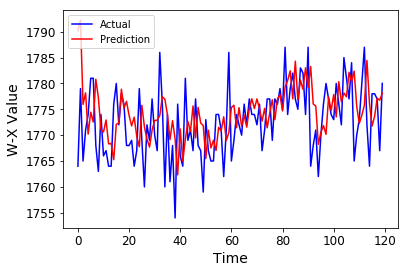

In [42]:

plt.plot(range(len(Y_test[0][:,0])),Y_test[0][:,0], color ='b', label ="Actual")

plt.plot(range(len(X_test[0][:,0])),y_pred[0][:,0], color='r',  label ="Prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("W-X Value")

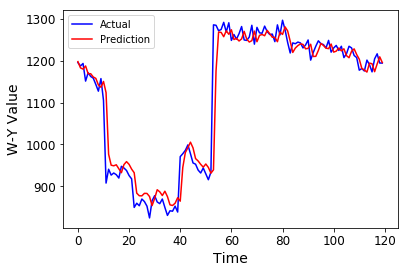

In [40]:


plt.plot(range(len(Y_test[1][:,1])),Y_test[1][:,1], color ='b', label ="Actual")

plt.plot(range(len(X_test[1][:,1])),y_pred[1][:,1], color='r',  label ="Prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("W-Y Value")

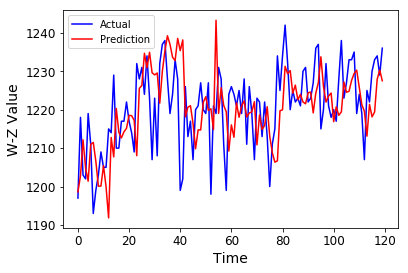

In [41]:

plt.plot(range(len(Y_test[1][:,2])),Y_test[1][:,2], color ='b', label ="Actual")

plt.plot(range(len(X_test[1][:,2])),y_pred[1][:,2], color='r',  label ="Prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("W-Z Value")


In [238]:
import random as rd
max_ind = train_data.shape[0]
def sm_next_batch(batch_size, n_steps):
    X = []
    Y = []
    for i in range(batch_size):
        start = rd.randint(0, max_ind-n_steps-1)
        ys1 = train_data[start: start+n_steps, 0:3]
        ys2 = train_data[start+1: start+n_steps+1,0:3]
        X.append(ys1)
        Y.append(ys2)
    X = np.array(X).reshape(-1, n_steps, 3)
    Y = np.array(Y).reshape(-1, n_steps, 3)
    
    return X, Y 
   

max_test_ind = test_data.shape[0]
def sm_test_next_batch(batch_size, n_steps):
    X = []
    Y = []
    for i in range(batch_size):
        start = rd.randint(0, max_test_ind-n_steps-1)
        ys1 = test_data[start: start+n_steps,0:3]
        ys2 = test_data[start+1: start+n_steps+1,0:3]
        X.append(ys1)
        Y.append(ys2)
    X = np.array(X).reshape(-1, n_steps, 3)
    Y = np.array(Y).reshape(-1, n_steps, 3)
    
    return X, Y 

In [239]:
tf.reset_default_graph()

n_steps = 120
n_inputs = 3
n_neurons = 100
n_outputs = 3
learning_rate = 0.001



X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)


loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()


In [240]:
n_iterations = 3000
sm_batch_size = 50
sm_n_steps = 120
sm_test_n_steps =20

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = sm_next_batch(sm_batch_size, sm_n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_test, Y_test = sm_test_next_batch(10, sm_n_steps)
    y_pred = sess.run(outputs, feed_dict={X: X_test})

0 	MSE: 2.26686e+10
100 	MSE: 1.38846e+08
200 	MSE: 5.03566e+07
300 	MSE: 1.3293e+07
400 	MSE: 1.4965e+07
500 	MSE: 1.25312e+07
600 	MSE: 1.02885e+07
700 	MSE: 1.36209e+07
800 	MSE: 8.41183e+06
900 	MSE: 8.36157e+06
1000 	MSE: 6.02249e+06
1100 	MSE: 7.60915e+06
1200 	MSE: 9.24895e+06
1300 	MSE: 8.25378e+06
1400 	MSE: 9.63815e+06
1500 	MSE: 5.8675e+06
1600 	MSE: 9.14575e+06
1700 	MSE: 1.08625e+07
1800 	MSE: 6.25292e+06
1900 	MSE: 8.68263e+06
2000 	MSE: 6.57095e+06
2100 	MSE: 1.21453e+07
2200 	MSE: 9.09366e+06
2300 	MSE: 9.74023e+06
2400 	MSE: 7.10286e+06
2500 	MSE: 8.63305e+06
2600 	MSE: 6.62906e+06
2700 	MSE: 8.20055e+06
2800 	MSE: 8.01896e+06
2900 	MSE: 4.78509e+06


In [241]:
def mse(pred, actual):
    pred = np.array(pred)
    print("pred length is ", len(pred))
    
    print("actual length is ", len(actual))
    actual = np.array(actual)
    return np.mean(pred-actual)**2
x_input_moving_avg = X_test[1,:,0]
windows = 4
x_pred_moving_avg = moving_avg_predictor(x_input_moving_avg, windows)
x_actual_moving_avg = X_test[1][windows:,0]
x_pred_moving_avg = moving_avg_predictor(x_input_moving_avg, windows)
moving_avg_mse_x = mse(x_pred_moving_avg, x_actual_moving_avg)
rnn_mse_x = mse(y_pred[1][:,0], Y_test[1][:,0])

print(" moving average MSE: ",moving_avg_mse_x)
print(" RNN  MSE: ",rnn_mse_x)



pred length is  116
actual length is  116
pred length is  120
actual length is  120
 moving average MSE:  4.18029131986e-05
 RNN  MSE:  1.82091831207


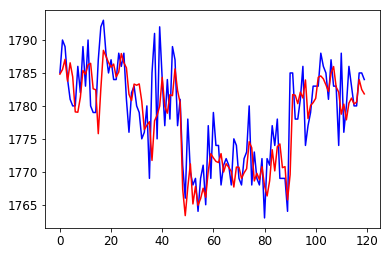

In [244]:
plt.plot(range(len(X_test[5][:,0])),X_test[5][:,0], color ='b')

plt.plot(range(len(X_test[5][:,0])),y_pred[5][:,0], color='r')